## Model Tuning for Note Transcription

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
import keras_tuner as kt
from keras_tuner.tuners import Hyperband
from build_train_set import buildTrainSet
from post_transcription import returnPvLabels
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
x_train, y_train, label_train, x_test, y_test, label_test, x_tune, y_tune, label_tune = buildTrainSet()
print((x_train.shape, y_train.shape), (x_test.shape, y_test.shape), (x_tune.shape, y_tune.shape))

((3638, 250, 1), (3638, 250, 13)) ((396, 250, 1), (396, 250, 13)) ((396, 250, 1), (396, 250, 13))


In [4]:
def build_model(hp):
    # initialize hyperparameters
    tune_units = hp.Int('n_units',min_value=64,max_value=512,step=64)
    tune_layers = hp.Int('n_layers',1,4)
    tune_dropout = hp.Float('dropout_rate',min_value=0,max_value=0.5,step=0.1)
    tune_lrate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

    # make model
    model = Sequential()
    model.add(LSTM(units=tune_units,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
    for i in range(tune_layers-1):
        model.add(LSTM(units=tune_units,return_sequences=True))
    model.add(Dropout(tune_dropout))
    model.add(Dense(13, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(tune_lrate),loss='categorical_crossentropy',metrics=['accuracy'])

    return model
        

In [5]:
tuner = Hyperband(
            hypermodel=build_model,
            objective='val_accuracy',
            max_epochs=10,
            factor=3,
            project_name='lstm_tuner',
            overwrite=False)

INFO:tensorflow:Reloading Tuner from .\lstm_tuner\tuner0.json


In [5]:
tuner.search(x_train, y_train, epochs=4, batch_size=250, validation_data=(x_test,y_test))

Trial 30 Complete [00h 25m 57s]
val_accuracy: 0.660767674446106

Best val_accuracy So Far: 0.7643333077430725
Total elapsed time: 06h 50m 50s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in .\lstm_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0026 summary
Hyperparameters:
n_units: 256
n_layers: 4
dropout_rate: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7643333077430725

Trial 0017 summary
Hyperparameters:
n_units: 256
n_layers: 4
dropout_rate: 0.4
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.753969669342041

Trial 0024 summary
Hyperparameters:
n_units: 384
n_layers: 3
dropout_rate: 0.2
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.7358384132385254

Trial 0025 summary
Hyperparameters:
n_units: 256
n_layers: 3
dropout_rate: 0.2
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.7334848642349243

Trial 0016 sum

## Model Training and Checking for Number of Epochs

In [9]:
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(250,1)))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(rate=0.3))
model.add(Dense(13, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 250, 256)          264192    
                                                                 
 lstm_6 (LSTM)               (None, 250, 256)          525312    
                                                                 
 lstm_7 (LSTM)               (None, 250, 256)          525312    
                                                                 
 lstm_8 (LSTM)               (None, 250, 256)          525312    
                                                                 
 dropout_2 (Dropout)         (None, 250, 256)          0         
                                                                 
 dense_2 (Dense)             (None, 250, 13)           3341      
                                                                 
Total params: 1,843,469
Trainable params: 1,843,469
No

In [10]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=250, validation_data=(x_test, y_test))

model.save('../ext/model_lstm.h5') # backup

Epoch 1/100
15/15 [==============================] - 372s 24s/step - loss: 2.3255 - accuracy: 0.2674 - val_loss: 2.1655 - val_accuracy: 0.3079
Epoch 2/100
15/15 [==============================] - 355s 24s/step - loss: 2.0404 - accuracy: 0.3205 - val_loss: 2.0213 - val_accuracy: 0.3299
Epoch 3/100
15/15 [==============================] - 359s 24s/step - loss: 1.9554 - accuracy: 0.3585 - val_loss: 1.8790 - val_accuracy: 0.3906
Epoch 4/100
15/15 [==============================] - 357s 24s/step - loss: 1.7626 - accuracy: 0.4081 - val_loss: 1.6616 - val_accuracy: 0.4222
Epoch 5/100
15/15 [==============================] - 356s 24s/step - loss: 1.4935 - accuracy: 0.4823 - val_loss: 1.3407 - val_accuracy: 0.5568
Epoch 6/100
15/15 [==============================] - 354s 24s/step - loss: 1.2523 - accuracy: 0.5666 - val_loss: 1.1792 - val_accuracy: 0.5861
Epoch 7/100
15/15 [==============================] - 351s 23s/step - loss: 1.0820 - accuracy: 0.6254 - val_loss: 0.9884 - val_accuracy: 0.6768

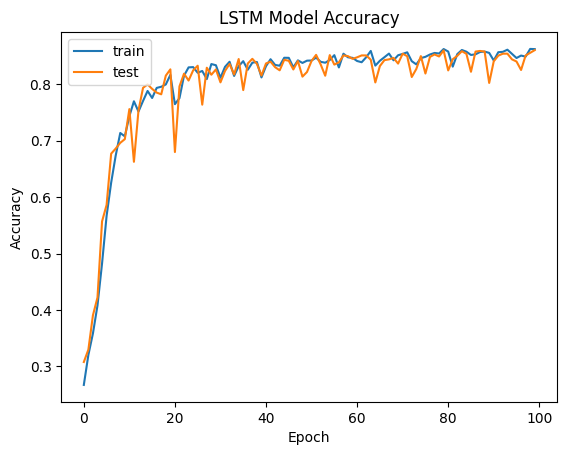

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

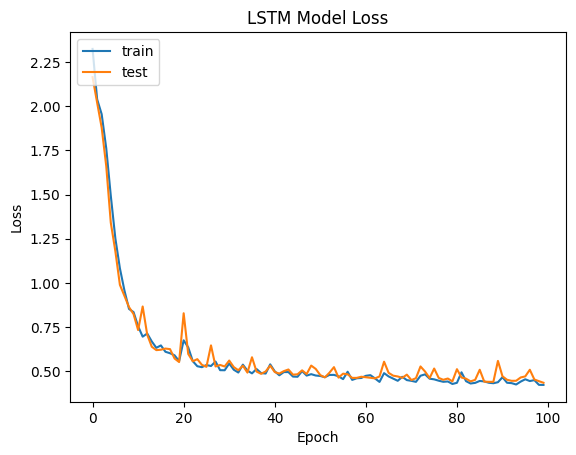

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_test.shape)

# for i in range(len(y_pred))

13/13 [==============================] - 21s 960ms/step
(396, 250, 13)
(396, 250, 13)


In [17]:
yp_labels = returnPvLabels(y_pred)
ya_labels = returnPvLabels(y_test)

for i in range(len(yp_labels)):
    print('---',i+1,'---')
    print('Predicted    :', yp_labels[i])
    print('Actual       :', ya_labels[i])

--- 1 ---
Predicted    : [11, 12, 12, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 10, 9, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 8, 7, 7, 7, 7, 7, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 12, 12, 12, 12, 1, 1, 12, 11, 11, 10, 11, 11, 11, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 1, 1, 1, 1, 1, 1, 12, 12, 11, 11, 10, 10, 10, 10, 10, 10, 11, 11, 10, 9, 9, 9, 9, 9, 9, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 0, 0, 0, 0, 10, 9, 10, 10, 9, 9, 9, 9, 8, 8, 8, 7, 8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Actual       : [1, 1, 12, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 12, 8, 7, 7, 9,